In [2]:
%matplotlib inline
import pandas as pd
from scipy.integrate import cumtrapz
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_full = pd.read_csv("ATNF_data_file.txt", sep=" ", skiprows=[0, 2, 3], header=0,
                 skipinitialspace=True, skipfooter=1, engine='python',
                 na_values="*")
df_full.head()

,NAME,F0,F1,F2,BINARY,PSR,AGE,Unnamed: 7
0,J0006+1834,1.441446,-4.357000e-15,NaN,NaN,NaN,5240000,NaN
1,J0007+7303,3.165827,-3.612000e-12,4.100000e-23,NaN,NRAD,13900,NaN
2,B0011+47,0.805997,-3.667000e-16,7.300000e-28,NaN,NaN,34800000,NaN
3,J0023+0923,327.868852,NaN,NaN,BT,HE,NaN,NaN
4,B0021-72C,173.708219,1.504000e-15,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df_full[~np.isnan(df_full['F2'])].copy().reindex()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 1 to 2524
Data columns (total 8 columns):
NAME          422 non-null object
F0            422 non-null float64
F1            422 non-null float64
F2            422 non-null float64
BINARY        24 non-null object
PSR           64 non-null object
AGE           421 non-null float64
Unnamed: 7    0 non-null float64
dtypes: float64(5), object(3)
memory usage: 29.7+ KB


In [5]:
df['nobs'] = df.F0 * df.F2/df.F1**2
df['tch'] = -df.F0 / (2*df.F1)
df['tch_years'] = df['tch'] / (86400 * 365)

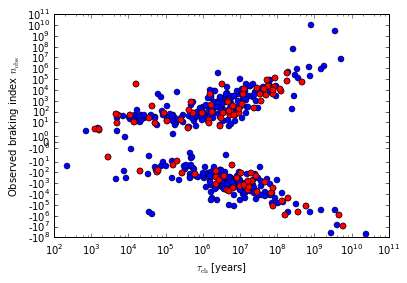

In [6]:
fig, ax = plt.subplots()

ax.semilogx(df['tch_years'], df['nobs'], "o")
ax.set_yscale("symlog")
ax.set_xlabel(r"$\tau_{\mathrm{ch}}$ [years]")
ax.set_ylabel(r"Observed braking index $n_{\mathrm{obs}}$")

tch = df['tch'].values[0:100]
nobs = df['nobs'].values[0:100]
ax.plot(tch/(86400*365), nobs, "or")

plt.show()

In [7]:
import emcee 
import triangle
import BDATools as BDA

def Generic_lnuniformprior(theta, theta_lims):
    """ Generic uniform priors on theta 
    
    Parameters
    ----------
    theta : array_like 
        Value of the parameters
    theta_lims: array_like of shape (len(theta), 2)
        Array of pairs [min, max] for each theta paramater
        
    """
    
    theta_lims = np.array(theta_lims)
    
    if all(theta - theta_lims[:, 0] > 0 ) and all(theta_lims[:, 1] - theta > 0):
        return np.prod(1.0/np.diff(theta_lims, axis=1))
    return -np.inf

def Generic_lnlike(theta, t, x, model):
    """ Generic likelihood function for signal in Gaussian noise
    
    Parameters
    ----------
    theta : array_like
        Value of the parameters, the noise strength `sigma` should ALWAYS be
        the last element in the list
    t : array_like
        The independant variable
    x : array_like
        The observed dependent variable
    model : func
        Signal model, calling `model(theta[:-1], t)` should
        produced the corresponding value of the signal 
        alone `x_val`, without noise. 
    
    """
    
    sigma2 = theta[-1]**2
    xmod = [model(ti, theta[:-1]) for ti in t]
    return -0.5*(np.sum((x-xmod)**2 / sigma2 + np.log(2*np.pi*sigma2))) 
 

def F1_func(t, tauAge, P, tauP, theta, chi, psi0):

    zeta = tauAge * P
    
    psi = 2*np.pi * (1/tauP) * t + psi0

    T1 = -1/(zeta)
    T2 = 3./(zeta*tauAge) * t

    T3 = 1./(zeta) * theta * (2*np.cos(chi)/np.sin(chi) * np.sin(psi)
                              - 0.5*theta*np.cos(2*psi))

    return (T1 + T2 + T3)/(2*np.pi)

time = np.linspace(0, 1e8, 100)

def SignalModel(tauAge, params):

    P, tauP, theta, chi, psi0 = params
    
    F0_0 = 1/P

    
    F1 = F1_func(time, tauAge, P, tauP, theta, chi, psi0)
    F0 = cumtrapz(y=F1, x=time, initial=0) + F0_0
    P0 = cumtrapz(y=F0, x=time, initial=0)

    coefs, V = np.polyfit(time, P0, deg=3, cov=True)

    mF2 = coefs[0]*6 * (2*np.pi)
    mF1 = coefs[1]*2 * (2*np.pi)
    mF0 = coefs[2]

    #errs = np.sqrt(np.diag(V))
    #mF2_err = errs[0]*6 * (2*np.pi)
    #mF1_err = errs[1]*2 * (2*np.pi)
    #mF0_err = errs[2]
        
    n = mF0 * mF2 / mF1**2 

    return n

logl = lambda theta, x, y: Generic_lnlike(theta, x, y, SignalModel)     

# Prior
theta_lims = [[0.0, 0.1], 
              [1e6, 1e7],
              [0, 1.0],
              [0., .1],
              [0, 1.0],
              [0, 2e9]
              ]
symbols = ['P', 'tauP', 'theta', 'chi', 'psi0', 'sigma']
logp = lambda theta: Generic_lnuniformprior(theta, theta_lims)   

/usr/local/lib/python2.7/dist-packages/matplotlib-1.5.dev1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:1321: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [8]:
ntemps = 1
nburn0 = 100
nburn = 100
nprod = 100
ndim = 6
nwalkers = 100
scatter_val = 1e-4

# Initialise the walkers
p0 = [[[np.random.uniform(tl[0], tl[1]) for tl in theta_lims] 
               for i in range(nwalkers)] for k in range(ntemps)]

# Run the sampler
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, logl, logp, loglargs=[tch, nobs])
sampler.use_parallel = False

BDA.MCMCMethod(sampler, p0, nwalkers, nprod, nburn, nburn0, symbols, True, scatter_val, ndim)

Run zeroth burn-in of 100 points to sample from
Plotting temperature 0 chains
Resample from zeroth burn-in
Running burn-in of 100 points and prod of 100 points
Running seriel MCMC simulation
Plotting temperature 0 chains


In [9]:
ndim = 6
nwalkers = 100

# Initialise the walkers
walker_pos = [[np.random.uniform(tl[0], tl[1]) for tl in theta_lims] 
               for i in range(nwalkers)] 

# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(tch, nobs))
out = sampler.run_mcmc(walker_pos, 1000)

NameError: name 'lnprob' is not defined

In [ ]:
sampler.chain.shape

In [ ]:
nburn=100
samples = sampler.chain[:, :, nburn:, :].reshape((-1, ndim))
triangle.corner(samples)
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.set_yscale("symlog")
ax.set_xlabel(r"$\tau_{\mathrm{ch}}$ [years]")
ax.set_ylabel(r"Observed braking index $n_{\mathrm{obs}}$")
ax.semilogx(tch, nobs, "or")

samples = sampler.chain[:, :, nburn:, :].reshape((-1, ndim))
x_sim_plot = np.linspace(1e10, max(tch), 10000) 
for s in samples[np.random.randint(len(samples), size=10)]:
    ysignal = [SignalModel(xs, s[:-1]) for xs in x_sim_plot]
    ax.plot(x_sim_plot, ysignal, "-", label="model",
            color='r', lw=0.8, alpha=1.0
            )
    noise_low = ysignal - s[-1]
    noise_high = ysignal + s[-1]
    ax.fill_between(x_sim_plot, noise_low,
                    noise_high, color='k', alpha=0.1)
        
plt.show()